In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import os
import re
from collections import namedtuple
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

_PRNG = np.random.RandomState(0)

In [2]:
_DATA_DIR = "./data"
_FILE_PROCESSED_DATASET = "lendingclub_2016-2018_processed.csv"
_FILE_PATH_PROCESSED_DATASET = Path(_DATA_DIR + "/" + _FILE_PROCESSED_DATASET)

_IS_PROCESSED_DATASET = False

df = None
# Read in the data, check if a preprocessed dataset exists
if _FILE_PATH_PROCESSED_DATASET.is_file():
    print("Preprocessed dataset found, reading preprocessed dataset")
    _IS_PROCESSED_DATASET = True
    df = pd.read_csv(_FILE_PATH_PROCESSED_DATASET)
else:
    # Read all data
    print("Preprocessed dataset not found, reading all data")
    _dataset_loan_columns = ["loan_amnt",
                             "int_rate",
                             "term",
                             "grade",
                             "sub_grade",
                             "installment",
                             "annual_inc",
                             "loan_status",
                             "verification_status",
                             "purpose"]

    dataset_loans = {}
    for file_name in os.listdir(_DATA_DIR):
        if file_name.endswith(".csv"):
            full_file_path = _DATA_DIR + "/" + file_name
            print(full_file_path)
            loan_period = re.search(r'\d{4}Q[0-4]{1}', file_name).group(0)
            dataset_loans[loan_period] = pd.read_csv(full_file_path, usecols=_dataset_loan_columns)[_dataset_loan_columns]
    
    # Combine all the data into a single dataframe
    print("Combining all the data into a single dataframe")
    for k, dataset in dataset_loans.items():
        if df is None:
            df = dataset
            continue
        df = df.append(dataset, ignore_index=True)

    del dataset_loans
        
    # Convert column types
    print("Converting column types")
    df["loan_amnt"] = df["loan_amnt"].astype(int)
    df["annual_inc"] = df["annual_inc"].astype(int)
    df["int_rate"] = df["int_rate"].apply(lambda int_rate: float(int_rate[:-1]))
    df["term"] = df["term"].apply(lambda term: int(re.search(r'\d+', term).group(0)))
    
    # Remove outliers
    # Annual income must be greater than 0 and less than 1 million
    # Assume 0 is an outlier
    # Assume millioniare+ are outliers
    print("Removing outliers")
    df = df.loc[(df["annual_inc"] > 0) & (df["annual_inc"] < 1000000)]
    
    # Convert non-ordinal categorical variables to binary vectors
    print("Convert non-ordinal categorical variables to binary vectors (this can take a while)")
    total_columns_to_process = len(df["verification_status"].unique()) + len(df["purpose"].unique())
    columns_processed = 0
    for verification_status in df["verification_status"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", verification_status)
        df["vs_" + verification_status] = df.apply(lambda row: int(row["verification_status"] == verification_status), axis=1)
    for purpose in df["purpose"].unique():
        columns_processed += 1
        print(f"[{columns_processed}/{total_columns_to_process}]", purpose)
        df["p_" + purpose] = df.apply(lambda row: int(row["purpose"] == purpose), axis=1)

    df.drop(columns=["verification_status"], inplace=True)
    df.drop(columns=["purpose"], inplace=True)
    
    # Save processed dataset for future use
    print("Saving processed dataset")
    df.to_csv(_FILE_PATH_PROCESSED_DATASET, index=False, header=True)
    
print("Done!")

Preprocessed dataset found, reading preprocessed dataset
Done!


In [3]:
print("Number of loans in combined dataset:", len(df))
df.head(5)

Number of loans in combined dataset: 1371066


,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational
0,5000,17.27,36,D,D2,178.94,62000,Fully Paid,1,0,...,0,0,0,0,0,0,0,0,0,0
1,22000,6.49,36,A,A2,674.18,134000,Current,0,1,...,0,0,0,0,0,0,0,0,0,0
2,30000,10.75,60,B,B4,648.54,125000,Fully Paid,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10000,16.29,36,D,D1,353.01,40000,Charged Off,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12000,9.75,36,B,B3,385.80,120000,Current,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check if we have any null values
df[df.isnull().any(axis=1)]

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc,loan_status,vs_Source Verified,vs_Verified,...,p_other,p_major_purchase,p_vacation,p_moving,p_medical,p_car,p_house,p_renewable_energy,p_wedding,p_educational


### Preprocessing

In [5]:
# Convert ordinal categorical variables to numerical
from sklearn.preprocessing import LabelEncoder  

le_grade = LabelEncoder()
df["grade"] = le_grade.fit_transform(df["grade"])

le_sub_grade = LabelEncoder()
df["sub_grade"] = le_sub_grade.fit_transform(df["sub_grade"])

In [6]:
df_pos = df.loc[df["loan_status"] == "Fully Paid"]
df_neg = df.loc[(df["loan_status"] == "Default") | (df["loan_status"] == "Charged Off")]

In [7]:
df_pos["loan_status"].value_counts()

Fully Paid    382014
Name: loan_status, dtype: int64

In [8]:
df_neg["loan_status"].value_counts()

Charged Off    108758
Default            35
Name: loan_status, dtype: int64

In [9]:
df_pos[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.117732,0.353937,0.114210,0.116027,0.958982,0.422926
int_rate,0.117732,1.000000,0.368597,0.962965,0.987197,0.155487,-0.099715
term,0.353937,0.368597,1.000000,0.357490,0.366070,0.136393,0.079493
grade,0.114210,0.962965,0.357490,1.000000,0.971276,0.148621,-0.099893
sub_grade,0.116027,0.987197,0.366070,0.971276,1.000000,0.151058,-0.108120
installment,0.958982,0.155487,0.136393,0.148621,0.151058,1.000000,0.403238
annual_inc,0.422926,-0.099715,0.079493,-0.099893,-0.108120,0.403238,1.000000


In [10]:
df_neg[["loan_amnt", "int_rate", "term", "grade", "sub_grade", "installment", "annual_inc"]].corr()

,loan_amnt,int_rate,term,grade,sub_grade,installment,annual_inc
loan_amnt,1.000000,0.191178,0.387081,0.187644,0.193173,0.945589,0.450970
int_rate,0.191178,1.000000,0.376418,0.962659,0.983896,0.248679,-0.066134
term,0.387081,0.376418,1.000000,0.372196,0.383811,0.142168,0.109504
grade,0.187644,0.962659,0.372196,1.000000,0.975763,0.238671,-0.068205
sub_grade,0.193173,0.983896,0.383811,0.975763,1.000000,0.244191,-0.070253
installment,0.945589,0.248679,0.142168,0.238671,0.244191,1.000000,0.419332
annual_inc,0.450970,-0.066134,0.109504,-0.068205,-0.070253,0.419332,1.000000


In [11]:
# Take a random even subsample
SUBSAMPLE_AMOUNT = 100000

df_pos = df_pos.sample(n=SUBSAMPLE_AMOUNT, replace=False, random_state=_PRNG)
df_neg = df_neg.sample(n=SUBSAMPLE_AMOUNT, replace=False, random_state=_PRNG)

df_pos.drop(columns=["loan_status"], inplace=True)
df_neg.drop(columns=["loan_status"], inplace=True)
print("Subsample pos:", len(df_pos))
print("Subsample neg:", len(df_neg))

Subsample pos: 100000
Subsample neg: 100000


In [12]:
# Combine subsamples
df_subsample_X = pd.concat([df_pos, df_neg], ignore_index=True, copy=True)
df_subsample_X = df_subsample_X.astype(float)
df_subsample_Y = [1] * len(df_pos) + [0] * len(df_neg)

assert len(df_subsample_X) == len(df_subsample_Y), "Dataset and labels must be the same size"

### Linear SVM

In [13]:
# Most libraries recommend a hard normalization, mapping the min and max values of a given dimension to [0,1]
# However, a soft normalization is also feasible using StandardScaler
# https://neerajkumar.org/writings/svm/
# https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [14]:
# Create train/test split
# The training set is much smaller due to computation constraints, SVMs have poor scalability
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, train_size=0.1, test_size=0.2, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 20000
Training label size: 20000
Test set size: 40000
Test label size: 40000


In [15]:
# Use grid search cross-validation to find the best C, using F1-score
parameters = {
    "C" : [2 ** power for power in range(-5, 9)]
}

parameters = {
    "C" : [0.0625]
}

clf = GridSearchCV(SVC(kernel="linear", cache_size=4000, probability=True, random_state=_PRNG), param_grid=parameters, scoring="f1", cv=5, refit=True, n_jobs=-1, verbose=1)
clf.fit(X_train, Y_train)
print (clf.best_score_, clf.best_params_)
clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


0.6493064613540077 {'C': 0.0625}


SVC(C=0.0625, cache_size=4000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True,
  random_state=<mtrand.RandomState object at 0x00000169402ABB40>,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
svm = clf.best_estimator_

svm.score(X_test, Y_test)

0.63395

In [17]:
for col_name, value in zip(df_pos.columns, svm.coef_.ravel()):
    print("{:20s} : {:.4f}".format(col_name, value))

loan_amnt            : -0.2157
int_rate             : -0.4589
term                 : -0.4049
grade                : -1.2391
sub_grade            : -1.6550
installment          : -0.2078
annual_inc           : 1.7214
vs_Source Verified   : -0.0036
vs_Verified          : -0.2193
vs_Not Verified      : 0.2229
p_credit_card        : 0.0495
p_debt_consolidation : 0.0717
p_small_business     : -0.2579
p_home_improvement   : 0.1465
p_other              : -0.0117
p_major_purchase     : 0.1555
p_vacation           : -0.0625
p_moving             : -0.0010
p_medical            : -0.2630
p_car                : 0.2664
p_house              : 0.0314
p_renewable_energy   : -0.1250
p_wedding            : 0.0000
p_educational        : 0.0000


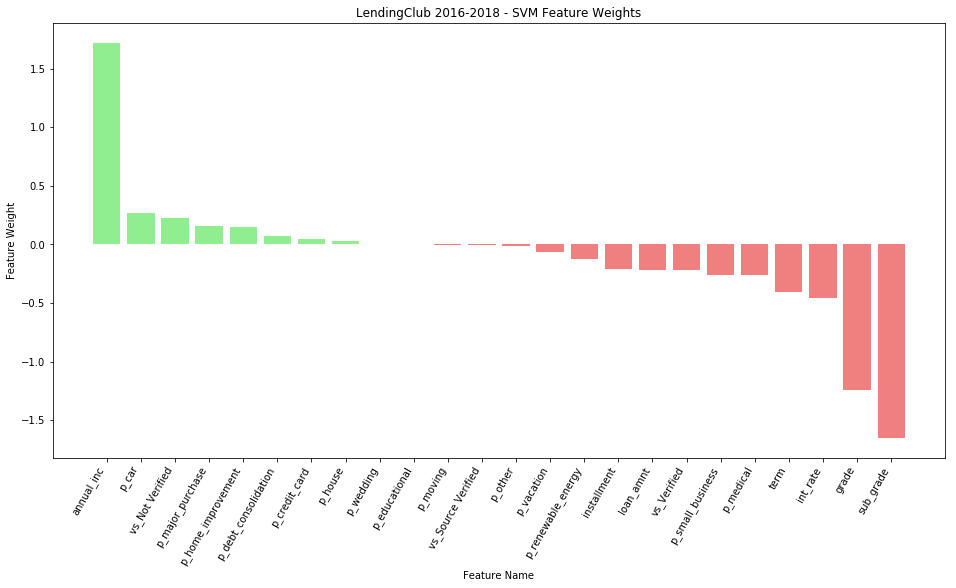

In [18]:
# Plot SVM feature weights
coef = svm.coef_.ravel()
coef_sorted = np.argsort(coef)[::-1]

col = list(df_pos.columns)
colors = ["lightcoral" if feature_weight < 0 else "lightgreen" for feature_weight in coef[coef_sorted]]

plt.figure(figsize=(16, 8))
plt.bar(list(range(len(coef))), coef[coef_sorted], color=colors)
plt.xticks(np.arange(0, len(coef)), [col[idx] for idx in coef_sorted], rotation=60, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Weight")
plt.title("LendingClub 2016-2018 - SVM Feature Weights")
plt.savefig("res/Prediction/SVM - Feature Weights.png", bbox_inches='tight')
plt.show()

In [19]:
svm.predict_proba(X_test[:10])

array([[0.68401085, 0.31598915],
       [0.62405154, 0.37594846],
       [0.40468161, 0.59531839],
       [0.48429661, 0.51570339],
       [0.65828996, 0.34171004],
       [0.81773383, 0.18226617],
       [0.23619164, 0.76380836],
       [0.32638946, 0.67361054],
       [0.40272865, 0.59727135],
       [0.55491817, 0.44508183]])

### Decision Tree

In [20]:
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [21]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [49]:
# Use random search to find best hyperparameters
parameters = {
    "max_depth"             : range(1, 31),
    "min_samples_split"     : range(2, 21),
    "min_samples_leaf"      : range(1, 11),
    "min_impurity_decrease" : np.arange(0, 0.05, 0.002),
    "max_features"          : ["sqrt", "log2", None]
}

parameters = {
    "max_depth"             : range(1, 11),
    "max_features"          : ["sqrt", "log2", None]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(criterion="gini", random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)
clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 30 is smaller than n_iter=250. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.0s finished


0.62392078908405 {'max_features': None, 'max_depth': 8}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=<mtrand.RandomState object at 0x00000169570DE678>,
            splitter='best')

In [43]:
decision_tree = clf.best_estimator_

decision_tree.score(X_test, Y_test)

0.64224

In [44]:
decision_tree.predict_proba(X_train[:10])

array([[0.24965278, 0.75034722],
       [0.48050089, 0.51949911],
       [0.48050089, 0.51949911],
       [0.38373005, 0.61626995],
       [0.57409777, 0.42590223],
       [0.65685653, 0.34314347],
       [0.49030823, 0.50969177],
       [0.65685653, 0.34314347],
       [0.71976172, 0.28023828],
       [0.77512887, 0.22487113]])

### RandomForest

In [50]:
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

df_subsample_scaled_X = scaler.fit_transform(df_subsample_X)

In [51]:
# Create train/test split
X_train, X_test, Y_train, Y_test = train_test_split(df_subsample_scaled_X, df_subsample_Y, test_size=0.125, stratify=df_subsample_Y, random_state=_PRNG)
print("Training set size:", len(X_train))
print("Training label size:", len(Y_train))
print("Test set size:", len(X_test))
print("Test label size:", len(Y_test))

Training set size: 175000
Training label size: 175000
Test set size: 25000
Test label size: 25000


In [55]:
# Use random search to find best hyperparameters
parameters = {
    "n_estimators"          : range(10, 200, 10),
    "max_depth"             : range(1, 31),
    "min_samples_split"     : range(2, 21),
    "min_samples_leaf"      : range(1, 11),
    "min_impurity_decrease" : np.arange(0, 0.05, 0.002),
    "max_features"          : ["sqrt", "log2", None]
}

parameters = {
    "max_depth"             : range(1, 5),
    "max_features"          : ["sqrt", "log2", None]
}

clf = RandomizedSearchCV(RandomForestClassifier(n_estimators=100, criterion="gini", n_jobs=-1, random_state=_PRNG), param_distributions=parameters, n_iter=250, scoring="f1", cv=5, refit=True, n_jobs=-1, random_state=_PRNG, verbose=1)

clf.fit(X_train, Y_train)

print(clf.best_score_, clf.best_params_)
clf.best_estimator_

C:\Users\juszhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 30 is smaller than n_iter=250. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 11.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x00000169417A7048>,
            verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'max_depth': range(1, 11), 'max_features': ['sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs',
          random_state=<mtrand.RandomState object at 0x00000169417A7048>,
          refit=True, return_train_score='warn', scoring='f1', verbose=1)

In [53]:
random_forest = clf.best_estimator_

random_forest.score(X_test, Y_test)

0.5978